<a href="https://colab.research.google.com/github/debojit11070/uber_data_science-project-with-advanced-statistical-methods/blob/main/uber_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import geopy.distance
from tqdm import tqdm
from IPython.display import display
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]
import warnings
warnings.filterwarnings('ignore')

## Data Exploratetion


In [43]:
df = pd.read_csv('/content/drive/MyDrive/datasets/uber.csv')

In [44]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [45]:
df.drop(['Unnamed: 0','key'], axis=1, inplace=True)

In [46]:
display(df.head())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [47]:
target = 'fare_amount'

In [48]:
features = [i for i in df.columns if i not in [target]]

In [49]:
features

['pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [50]:
print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))


Inference: The Datset consists of 7 features & 200000 samples.


## checking missing values

In [51]:
nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns = ['Total Null Values'])

In [52]:
nvc

,Total Null Values
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
passenger_count,0
dropoff_longitude,1
dropoff_latitude,1


In [53]:
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100

In [54]:
print(nvc)

                   Total Null Values  Percentage
fare_amount                        0         0.0
pickup_datetime                    0         0.0
pickup_longitude                   0         0.0
pickup_latitude                    0         0.0
passenger_count                    0         0.0
dropoff_longitude                  1         0.0
dropoff_latitude                   1         0.0


In [55]:
df.dropna(inplace = True)

The number of missing values is very small. so we can drop it.


In [56]:
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [57]:
df.shape

(199999, 7)

##Feature Engineering

1. Filters out invalid latitude/longitude values (outside ±90° for latitude, ±180° for longitude).
Converts pickup_datetime to a datetime object and extracts:

year, month, weekday, hour.


2. Creates categorical features:

Monthly_Quarter: Groups months into quarters (e.g., Jan-Mar → Q1).
Hourly_Segments: Groups hours into segments (e.g., 0-3 → H1, 4-7 → H2).


3. Calculates Distance (in meters) between pickup and dropoff coordinates using geopy.distance.
Drops pickup_datetime, month, and hour to avoid redundancy.
Creates a deep copy (original_df) to preserve the processed dataset.

**Impact**: Adds meaningful features (Distance, Monthly_Quarter, Hourly_Segments) that capture spatial and temporal patterns, improving model performance.

In [58]:
df = df[(df.pickup_latitude<90) & (df.dropoff_latitude<90) &
        (df.pickup_latitude>-90) & (df.dropoff_latitude>-90) &
        (df.pickup_longitude<180) & (df.dropoff_longitude<180) &
        (df.pickup_longitude>-180) & (df.dropoff_longitude>-180)]

In [59]:
df.pickup_datetime=pd.to_datetime(df.pickup_datetime)
df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour

In [60]:
df['Monthly_Quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
                                      8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})
df['Hourly_Segments'] = df.hour.map({0:'H1',1:'H1',2:'H1',3:'H1',4:'H2',5:'H2',6:'H2',7:'H2',8:'H3',
                                     9:'H3',10:'H3',11:'H3',12:'H4',13:'H4',14:'H4',15:'H4',16:'H5',
                                     17:'H5',18:'H5',19:'H5',20:'H6',21:'H6',22:'H6',23:'H6'})

In [61]:
df['Distance']=[round(geopy.distance.distance((df.pickup_latitude[i], df.pickup_longitude[i]),(df.dropoff_latitude[i], df.dropoff_longitude[i])).m,2) for i in df.index]
df.drop(['pickup_datetime','month', 'hour',], axis=1, inplace=True)
original_df = df.copy(deep=True)


In [62]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,3,Q2,H5,1681.11
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,4,Q3,H6,2454.36
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,0,Q3,H6,5039.60
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,4,Q2,H3,1661.44
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,3,Q3,H5,4483.73


##Data Inspection

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199987 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199987 non-null  float64
 1   pickup_longitude   199987 non-null  float64
 2   pickup_latitude    199987 non-null  float64
 3   dropoff_longitude  199987 non-null  float64
 4   dropoff_latitude   199987 non-null  float64
 5   passenger_count    199987 non-null  int64  
 6   year               199987 non-null  int32  
 7   weekday            199987 non-null  int32  
 8   Monthly_Quarter    199987 non-null  object 
 9   Hourly_Segments    199987 non-null  object 
 10  Distance           199987 non-null  float64
dtypes: float64(6), int32(2), int64(1), object(2)
memory usage: 20.8+ MB


In [64]:
df.nunique().sort_values()

,0
Monthly_Quarter,4
Hourly_Segments,6
year,7
weekday,7
passenger_count,8
fare_amount,1244
pickup_longitude,71055
dropoff_longitude,76890
pickup_latitude,83831
dropoff_latitude,90582


In [65]:
nu = df.drop([target], axis=1).nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0
# nf - numerical features, cf - categorical features

In [66]:
for i in range(df.drop([target], axis=1).shape[1]):
    if nu.values[i]<=24: cf.append(nu.index[i])
    else: nf.append(nu.index[i])

In [67]:
print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))
display(df.describe())


Inference: The Datset has 5 numerical & 5 categorical features.


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Distance
count,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,1.999870e+05
mean,11.359849,-72.501786,39.917937,-72.511608,39.922031,1.684544,2011.742463,3.048383,2.056346e+04
std,9.901868,10.449955,6.130412,10.412192,6.117669,1.385999,1.856438,1.946960,3.796638e+05
min,-52.000000,-93.824668,-74.015515,-75.458979,-74.015750,0.000000,2009.000000,0.000000,0.000000e+00
25%,6.000000,-73.992064,40.734793,-73.991407,40.733823,1.000000,2010.000000,1.000000,1.215530e+03
50%,8.500000,-73.981822,40.752592,-73.980092,40.753042,1.000000,2012.000000,3.000000,2.121280e+03
75%,12.500000,-73.967154,40.767157,-73.963658,40.768000,2.000000,2013.000000,5.000000,3.874255e+03
max,499.000000,40.808425,48.018760,40.831932,45.031598,208.000000,2015.000000,6.000000,8.783594e+06


## Ecploratory data analysis (EDA)

## visualizing categorical features

                               Visualising Categorical Features:                                


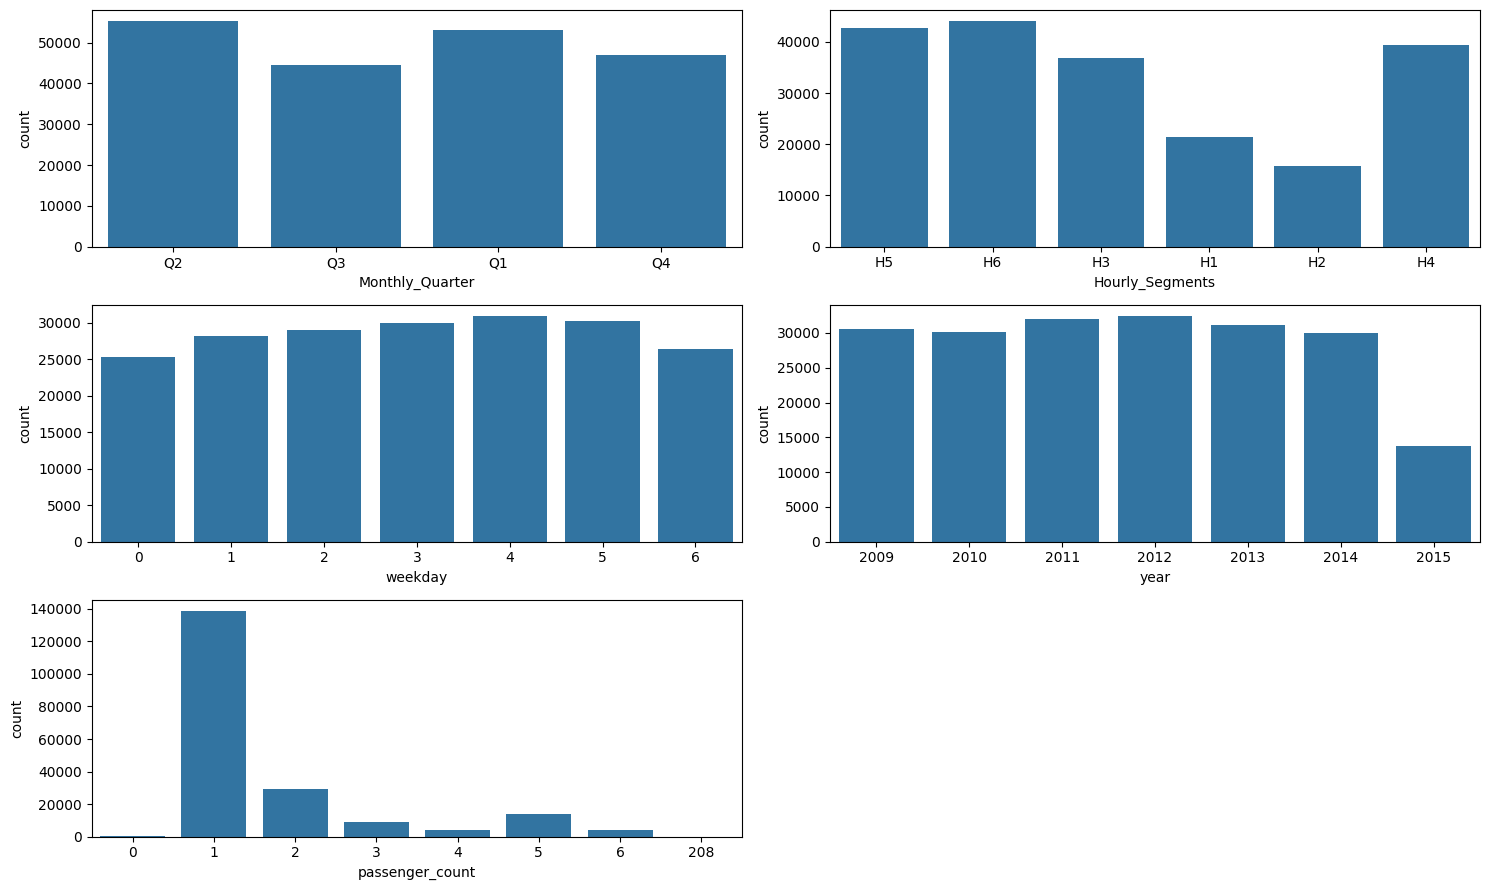

In [68]:
print('\033[1mVisualising Categorical Features:'.center(100))
n = 2
plt.figure(figsize=[15, 3 * math.ceil(len(cf) / n)])
for i in range(len(cf)):
    plt.subplot(math.ceil(len(cf) / n), n, i + 1)
    sns.countplot(x=df[cf[i]])  # Use x for countplot
plt.tight_layout()
plt.show()

## visualizign numerical features

                                 Numeric Features Distribution                                  


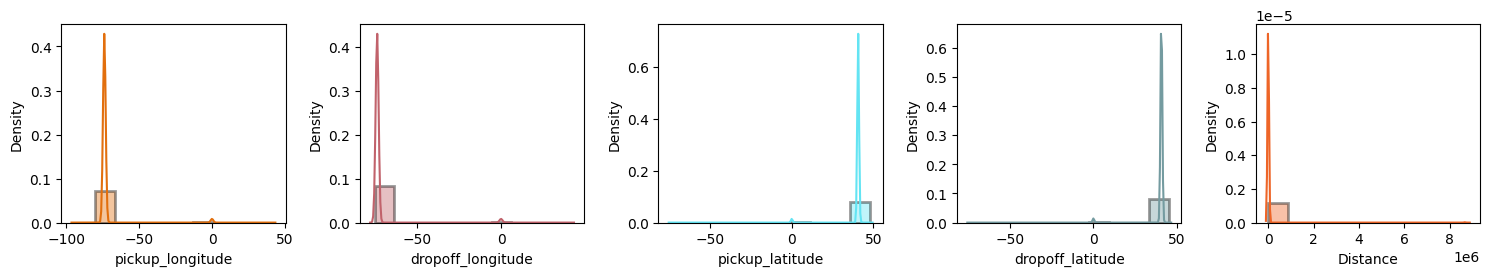

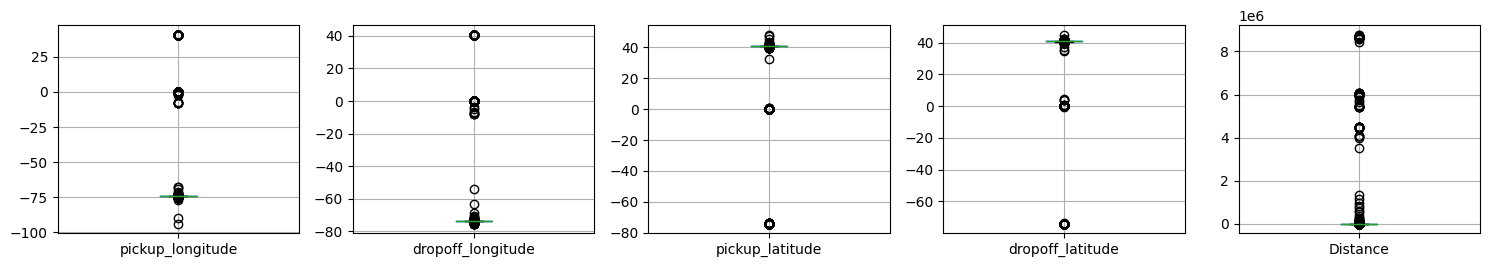

In [69]:
print('\033[1mNumeric Features Distribution'.center(100))
n=5
plt.figure(figsize=[15,5*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()
plt.figure(figsize=[15,5*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

## geographical visualization

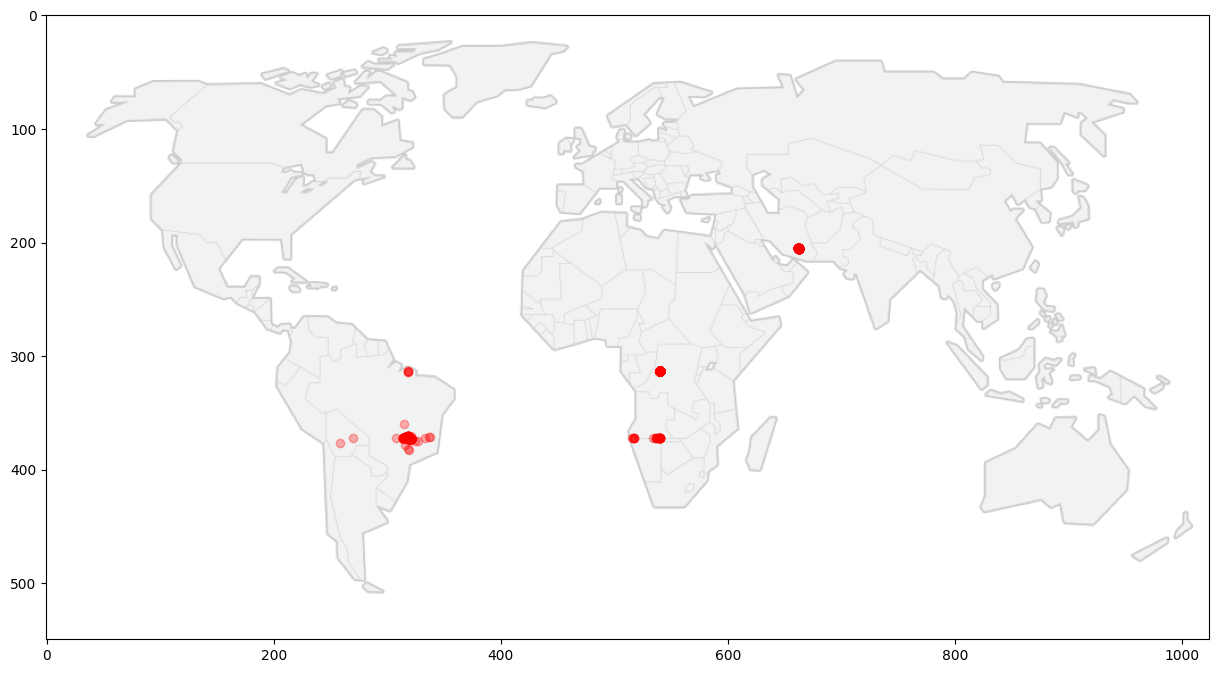

In [70]:
import urllib.request
from PIL import Image

plt.figure(figsize=[15,10])
# Open the URL and read the image using Pillow
with urllib.request.urlopen('https://raw.githubusercontent.com/Masterx-AI/Project_Uber_Fare_Prediction/main/wm.png') as url:
    a = np.array(Image.open(url))

plt.imshow(a, alpha=0.2)
plt.scatter((df.pickup_longitude+180)*3,(df.pickup_latitude+215)*1.45555555,alpha=0.3, color='red')
plt.show()

## Data Preprocessing

Duplicate removal

In [71]:
counter = 0
rs,cs = original_df.shape
df.drop_duplicates(inplace=True)
df.drop(['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],axis=1)
if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: Number of duplicates dropped/fixed ---> 109


In [72]:
df.shape

(199878, 11)

# categorical encoding

In [73]:
df1 = df.copy()
df3 = df1.copy()

In [74]:
ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]

In [75]:
oh=True #one hot encoding
dm=True # dummy encoding
for i in fcc:
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
df3.shape


Dummy Encoding on features:
Monthly_Quarter
Hourly_Segments
weekday
year
passenger_count


(199878, 33)

# removing outlier

In [76]:
df1 = df3.copy()
features1 = nf
for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,...,year_2013,year_2014,year_2015,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1681.11,True,False,False,False,...,False,False,True,True,False,False,False,False,False,False
1,7.7,-73.994355,40.728225,-73.994710,40.750325,2454.36,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
2,12.9,-74.005043,40.740770,-73.962565,40.772647,5039.60,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
3,5.3,-73.976124,40.790844,-73.965316,40.803349,1661.44,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,4.9,-73.969019,40.755910,-73.969019,40.755910,0.00,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False



Inference:
Before removal of outliers, The dataset had 199878 samples.
After removal of outliers, The dataset now has 163203 samples.


# final dataset visualization

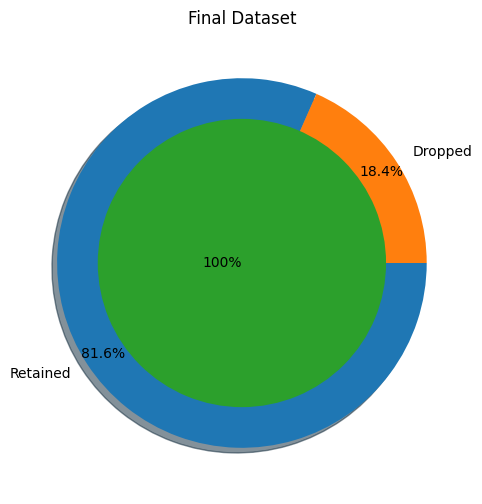


Inference: After the cleanup process, 36784 samples were dropped, while retaining 18.39% of the data.


In [77]:
df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]
plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False,
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()
print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

## Data Manipulation

# Train Test split

In [78]:
m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)
print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (163203, 32) (163203,) 
Training set  --->  (130562, 32) (130562,) 
Testing set   --->  (32641, 32)  (32641,)


## Feature Scaling

In [79]:
std = StandardScaler()
print('\033[1mStandardardization on Training set'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())
print('\n','\033[1mStandardardization on Testing set'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                               Standardardization on Training set                               


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,Hourly_Segments_H3,...,year_2013,year_2014,year_2015,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
count,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,...,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05
mean,-6.304811e-13,-2.329963e-15,-1.254833e-13,1.805402e-14,-8.463960e-17,3.570074e-17,-1.414968e-17,6.312936e-18,6.639467e-17,4.767355e-17,...,-2.176875e-19,-8.032667e-17,5.638105e-17,8.032667e-17,1.088437e-17,4.070755e-17,-1.904765e-18,-5.703411e-17,1.262587e-17,4.081640e-19
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.961437e+00,-2.897556e+00,-2.919757e+00,-2.867446e+00,-1.622863e+00,-6.155085e-01,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.281254e-01,-4.167818e-01,-2.720636e-01,-1.505327e+00,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
25%,-6.783829e-01,-6.847366e-01,-6.710313e-01,-6.636110e-01,-7.629052e-01,-6.155085e-01,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.281254e-01,-4.167818e-01,-2.720636e-01,-1.505327e+00,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
50%,-6.341797e-02,3.271920e-02,-6.532058e-02,4.834418e-02,-2.347775e-01,-6.155085e-01,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.281254e-01,-4.167818e-01,-2.720636e-01,6.643075e-01,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
75%,6.429738e-01,6.539807e-01,6.174684e-01,6.350862e-01,5.652279e-01,1.624673e+00,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.281254e-01,-4.167818e-01,-2.720636e-01,6.643075e-01,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
max,3.255964e+00,2.807711e+00,3.137233e+00,2.805374e+00,2.933357e+00,1.624673e+00,1.881034e+00,1.799003e+00,3.613456e+00,2.051975e+00,...,2.335764e+00,2.399337e+00,3.675611e+00,6.643075e-01,2.425547e+00,4.605646e+00,6.741425e+00,3.651694e+00,6.828835e+00,3.613323e+02



                                Standardardization on Testing set                                


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,Hourly_Segments_H3,...,year_2013,year_2014,year_2015,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
count,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,...,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,3.264100e+04
mean,0.009496,0.003957,0.002645,0.010718,0.003829,-0.004419,0.008474,-0.004463,0.001664,0.002463,...,0.001602,0.005796,-0.000427,-0.005507,0.003732,-0.006578,0.000262,0.001559,0.013835,-2.767536e-03
std,1.002215,1.000929,0.993715,1.001776,1.001768,0.997773,1.005681,0.997227,1.002787,1.001937,...,1.001541,1.005727,0.999288,1.002313,1.003758,0.985453,1.000877,1.002644,1.045127,1.405581e-15
min,-2.708732,-2.887521,-2.876670,-2.857408,-1.622863,-0.615509,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.428125,-0.416782,-0.272064,-1.505327,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
25%,-0.674309,-0.688962,-0.664415,-0.652657,-0.762707,-0.615509,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.428125,-0.416782,-0.272064,-1.505327,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
50%,-0.048188,0.048564,-0.060663,0.060627,-0.230528,-0.615509,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.428125,-0.416782,-0.272064,0.664307,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
75%,0.653268,0.661489,0.621690,0.657956,0.574644,1.624673,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.428125,-0.416782,-0.272064,0.664307,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
max,3.252830,2.800652,3.132185,2.804325,2.932838,1.624673,1.881034,1.799003,3.613456,2.051975,...,2.335764,2.399337,3.675611,0.664307,2.425547,4.605646,6.741425,3.651694,6.828835,-2.767536e-03


# feature selection / extraction

                                       Correlation Matrix                                       


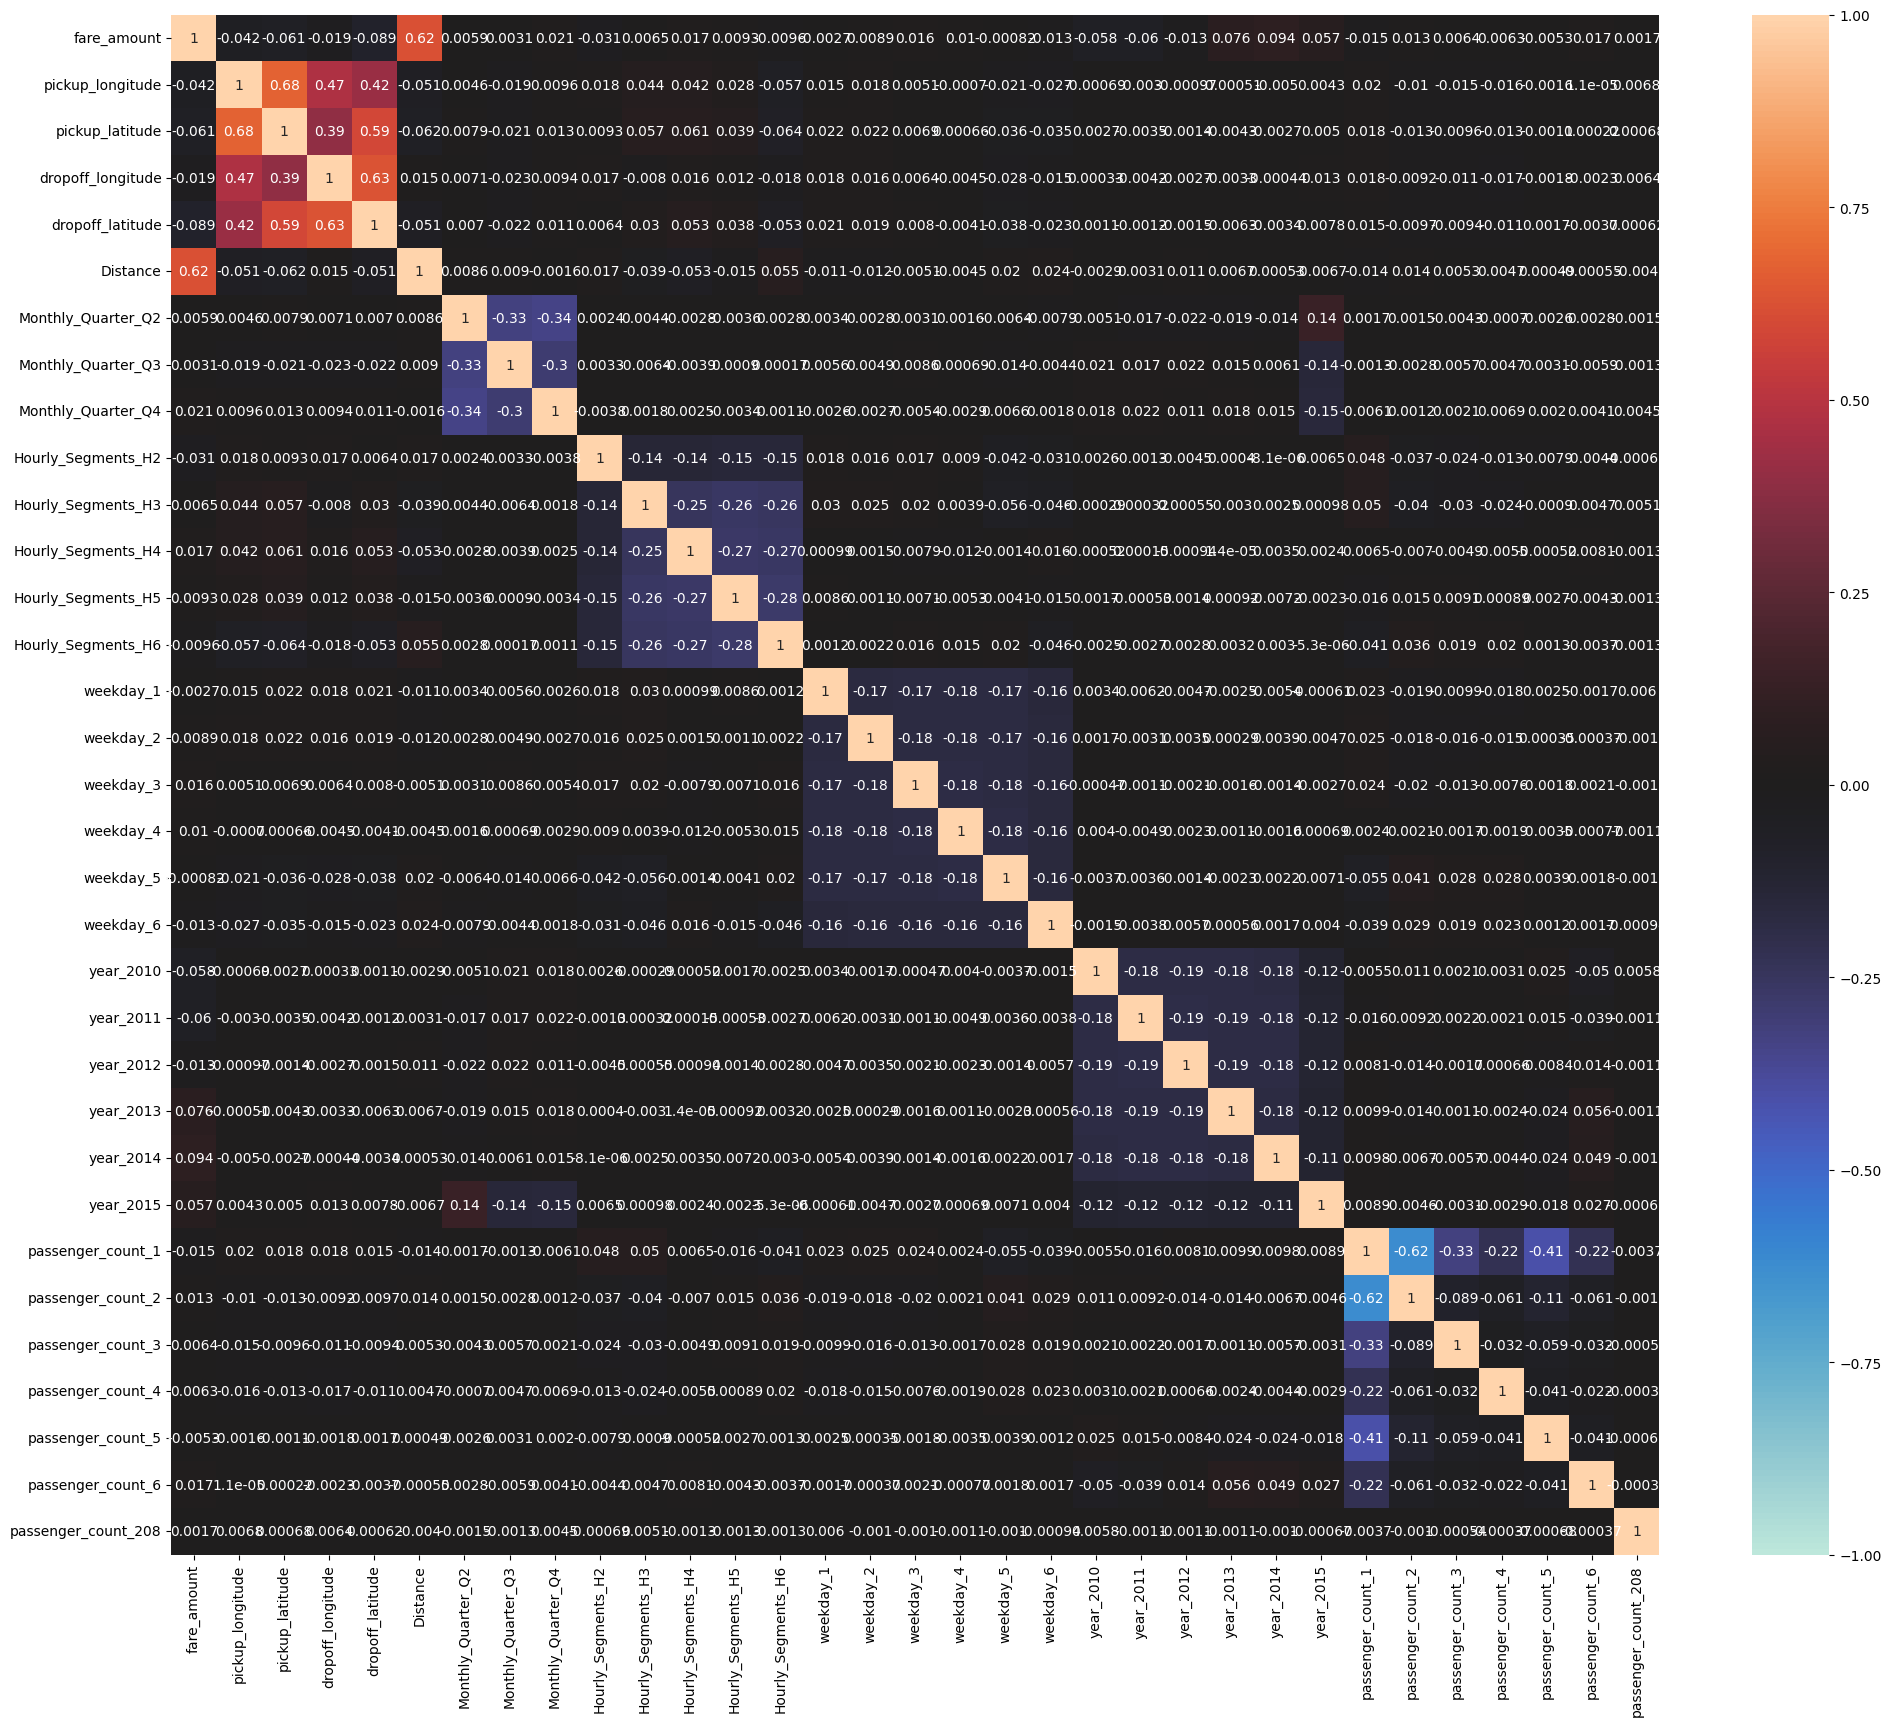

In [80]:
print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[24,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.show()

# Variancce inflation factor

100%|██████████| 31/31 [05:23<00:00, 10.45s/it]

Dropped Features -->  ['passenger_count_1', 'Hourly_Segments_H5', 'pickup_latitude', 'weekday_4', 'dropoff_longitude', 'year_2012', 'Monthly_Quarter_Q4', 'Hourly_Segments_H6', 'weekday_5', 'year_2011', 'pickup_longitude', 'weekday_2', 'Monthly_Quarter_Q3', 'year_2013', 'Hourly_Segments_H3']


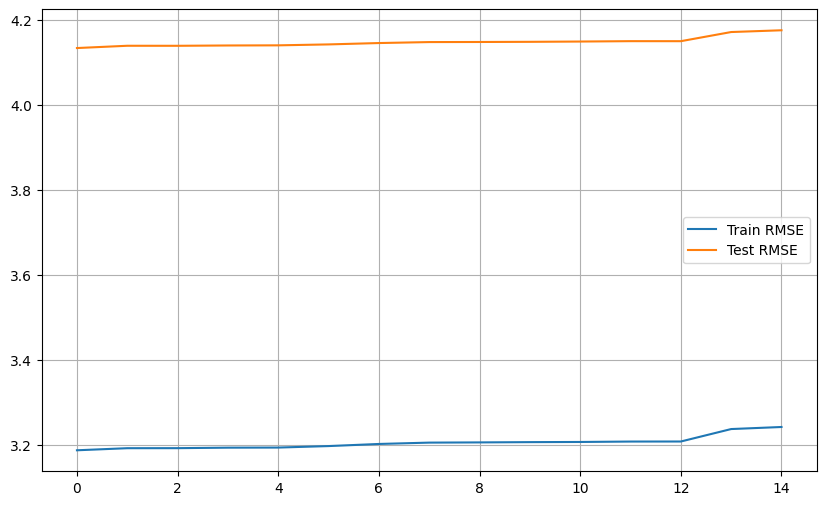

In [81]:
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
DROP=[]
for i in tqdm(range(len(Train_X_std.columns)-1)):
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>=1.1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)
        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))
        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))
print('Dropped Features --> ',DROP)
plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

# Recursive Feature Elimination

100%|██████████| 31/31 [05:38<00:00, 10.92s/it]

Dropped Features -->  ['passenger_count_1', 'Hourly_Segments_H5', 'pickup_latitude', 'weekday_4', 'dropoff_longitude', 'year_2012', 'Monthly_Quarter_Q4', 'Hourly_Segments_H6', 'weekday_5', 'year_2011', 'pickup_longitude', 'weekday_2', 'Monthly_Quarter_Q3', 'year_2013', 'Hourly_Segments_H3']


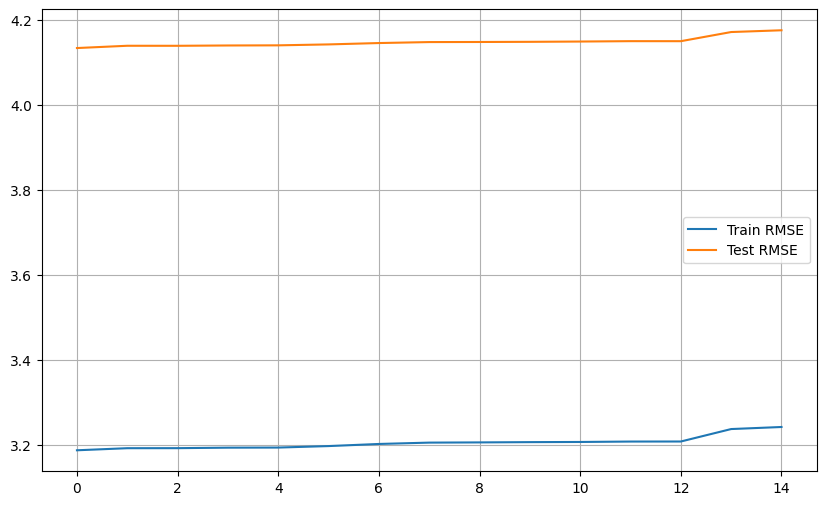

In [82]:
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
DROP=[]
for i in tqdm(range(len(Train_X_std.columns)-1)):
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>=1.1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)
        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))
        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))
print('Dropped Features --> ',DROP)
plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

## Principal component analysis (PCA)

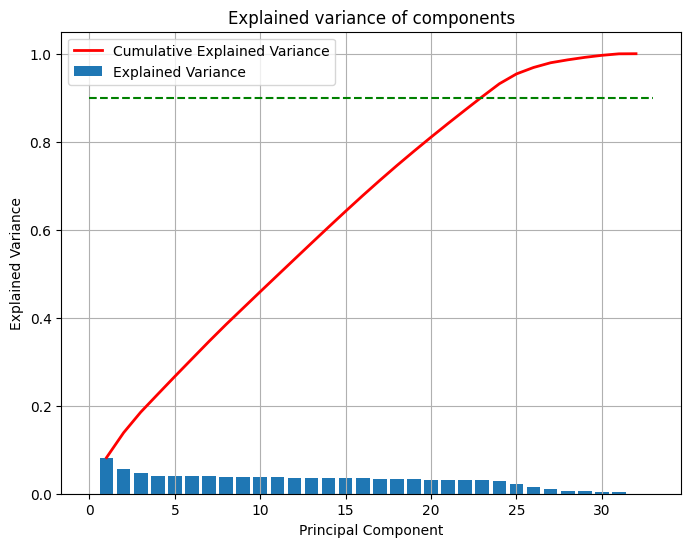

100%|██████████| 29/29 [00:07<00:00,  3.96it/s]


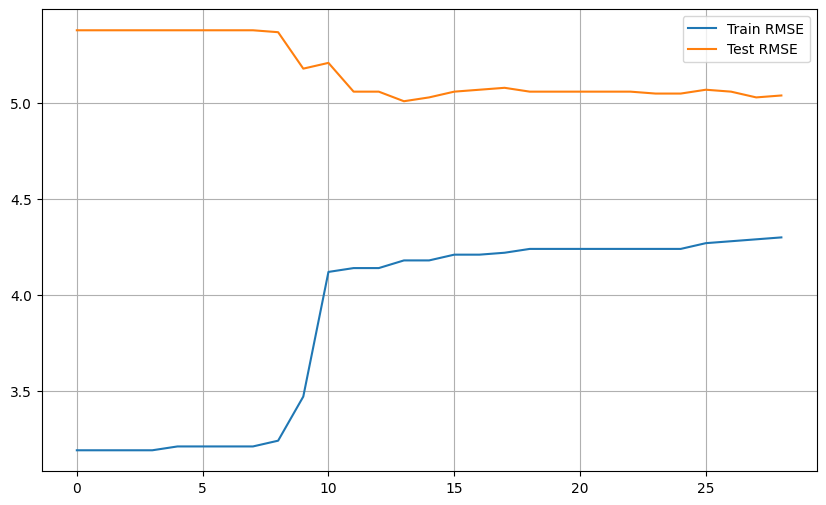

In [83]:
pca = PCA().fit(Train_X_std)
fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.9,0.9],'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
m=df.shape[1]-4
for i in tqdm(range(m)):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Test_X_std_pca = pca.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(Train_X_std_pca, Train_Y)
    pred1 = LR.predict(Train_X_std_pca)
    pred2 = LR.predict(Test_X_std_pca)
    Trr.append(round(np.sqrt(mean_squared_error(Train_Y, pred1)),2))
    Tss.append(round(np.sqrt(mean_squared_error(Test_Y, pred2)),2))
plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

## Final feature selection

In [84]:
lm = LinearRegression()
rfe = RFE(lm,n_features_to_select=df.shape[1]-23)
rfe = rfe.fit(Train_X_std, Train_Y)
LR = LinearRegression()
LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)
pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])
print(np.sqrt(mean_squared_error(Train_Y, pred1)))
print(np.sqrt(mean_squared_error(Test_Y, pred2)))
Train_X_std = Train_X_std.loc[:,rfe.support_]
Test_X_std = Test_X_std.loc[:,rfe.support_]

3.198334765136796
4.1370260899811235


## Predictive model

In [88]:
Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([7,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>50].columns,3)
def Evaluate(n, pred1,pred2):
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

In [90]:
print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))
print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
print('Mean Squared Error (MSE) on Testing set       --->',round(mean_squared_error(Test_Y, pred2),20))
print('Root Mean Squared Error (RMSE) on Testing set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
print('\n{}Residual Plots{}'.format('-'*20, '-'*20))



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.4535189574339896
Residual Sum of Squares (RSS) on Training set  ---> 1335563.7771264177
Mean Squared Error (MSE) on Training set       ---> 10.229345269882645
Root Mean Squared Error (RMSE) on Training set ---> 3.198334765136796

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.32820758401113337
Residual Sum of Squares (RSS) on Training set  ---> 558650.2211150513
Mean Squared Error (MSE) on Testing set       ---> 17.1149848691845
Root Mean Squared Error (RMSE) on Testing set ---> 4.1370260899811235

--------------------Residual Plots--------------------


In [92]:
Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

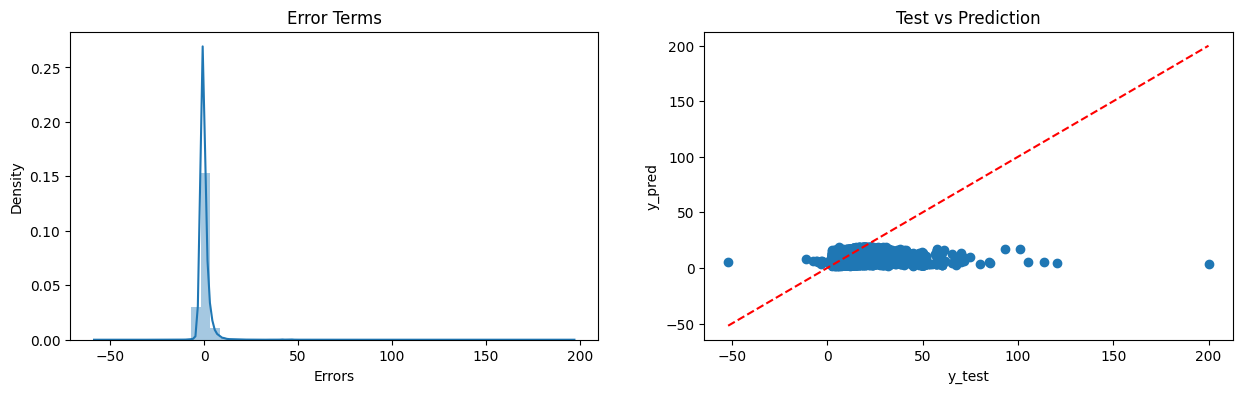

In [93]:
plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
sns.distplot((Train_Y - pred1))
plt.title('Error Terms')
plt.xlabel('Errors')
plt.subplot(1,2,2)
plt.scatter(Train_Y,pred1)
plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
plt.title('Test vs Prediction')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

## Multiple Linear Regression  (MLR)

<<<------------------------- Evaluating Multiple Linear Regression Model ------------------------->>>

The Coefficient of the Regression Model was found to be  [-0.30499538  2.79702093  0.15508619  0.32086946  0.39552625  0.29085972
  0.16782406  0.50924681  0.59332707  0.44376597]
The Intercept of the Regression Model was found to be  8.550616948269791


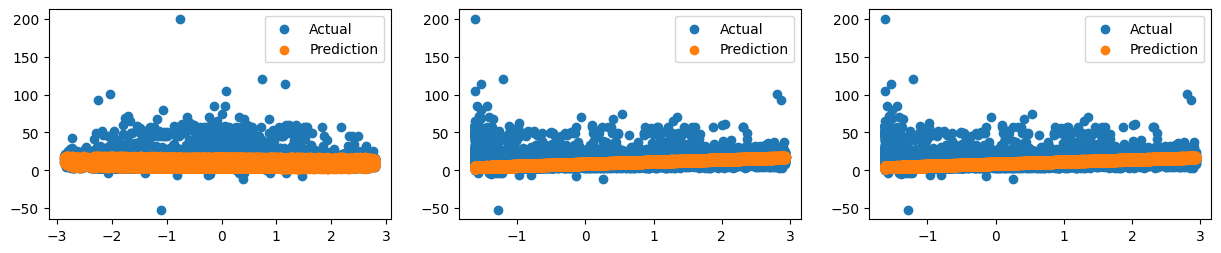

In [95]:
MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)
print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coefficient of the Regression Model was found to be ',MLR.coef_)
print('The Intercept of the Regression Model was found to be ',MLR.intercept_)
Evaluate(0, pred1, pred2)

## Ridge Regression

<<<------------------------- Evaluating Ridge Regression Model ------------------------->>>

The Coefficient of the Regression Model was found to be  [-0.30499328  2.79699889  0.15508437  0.32086245  0.39551852  0.2908531
  0.1678198   0.50924036  0.59331995  0.44376004]
The Intercept of the Regression Model was found to be  8.550616948269791


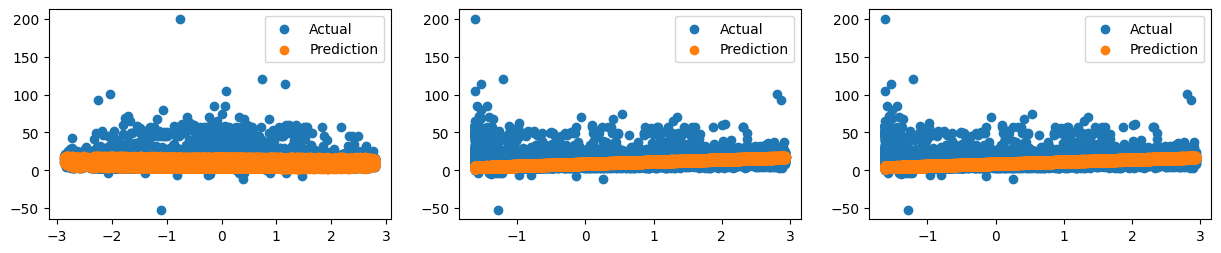

In [96]:
RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)
print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coefficient of the Regression Model was found to be ',RLR.coef_)
print('The Intercept of the Regression Model was found to be ',RLR.intercept_)
Evaluate(1, pred1, pred2)

## Lasso Regression (LLR)

<<<------------------------- Evaluating Lasso Regression Model ------------------------->>>

The Coefficient of the Regression Model was found to be  [-0.          1.77696753  0.          0.          0.          0.
 -0.          0.          0.          0.        ]
The Intercept of the Regression Model was found to be  8.550616948269786


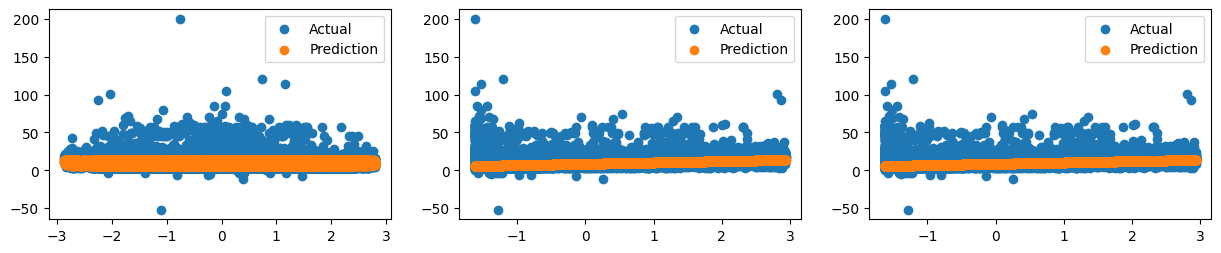

In [97]:
LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)
print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coefficient of the Regression Model was found to be ',LLR.coef_)
print('The Intercept of the Regression Model was found to be ',LLR.intercept_)
Evaluate(2, pred1, pred2)

## Elastic Net Regression (ENR)

<<<------------------------- Evaluating Elastic-Net Regression Model ------------------------->>>

The Coefficient of the Regression Model was found to be  [-0.          1.51797836  0.          0.          0.          0.
 -0.          0.          0.          0.        ]
The Intercept of the Regression Model was found to be  8.550616948269786


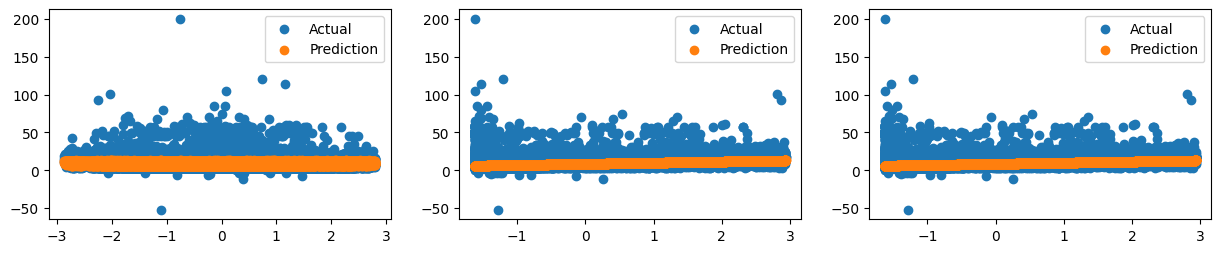

In [98]:
ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)
print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coefficient of the Regression Model was found to be ',ENR.coef_)
print('The Intercept of the Regression Model was found to be ',ENR.intercept_)
Evaluate(3, pred1, pred2)

## Polynomial Regression (PNR)

In [100]:
Trr=[]; Tss=[]
n_degree=6
for i in range(2,n_degree):
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)
    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

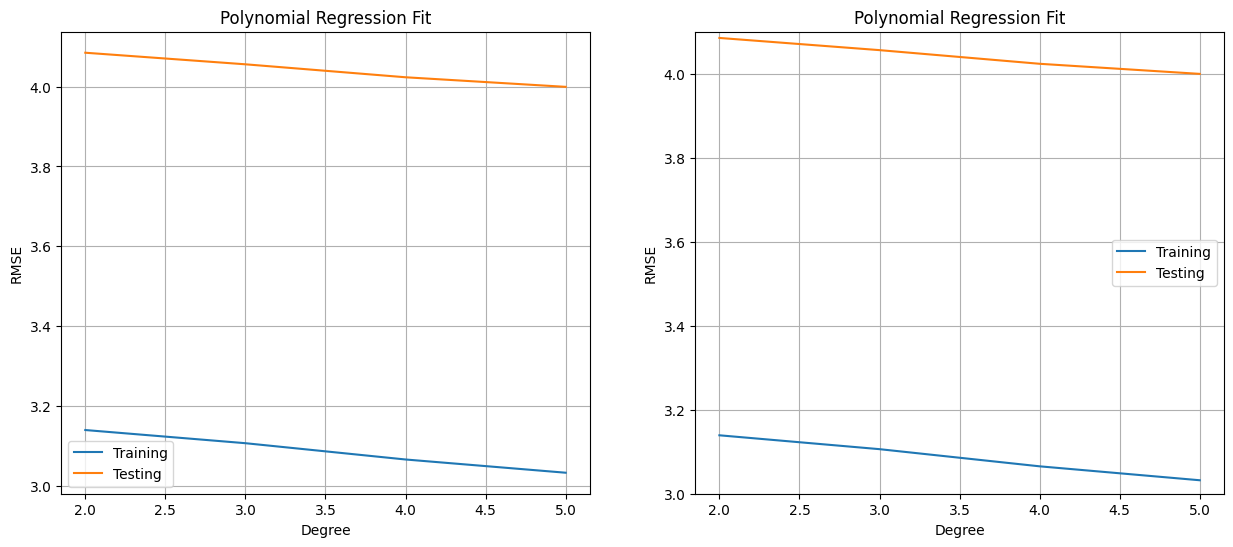

In [101]:
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([3,4.1])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.show()

In [102]:
poly_reg = PolynomialFeatures(degree=5)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)
pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

<<<------------------------- Evaluating Polynomial Regression Model ------------------------->>>

The Coefficient of the Regression Model was found to be  [ 1.49708552e-17 -1.34084260e-02  5.18017822e-01 ...  1.04233684e-05
 -2.89936809e-04  2.58466474e-03]
The Intercept of the Regression Model was found to be  7.641581309389016


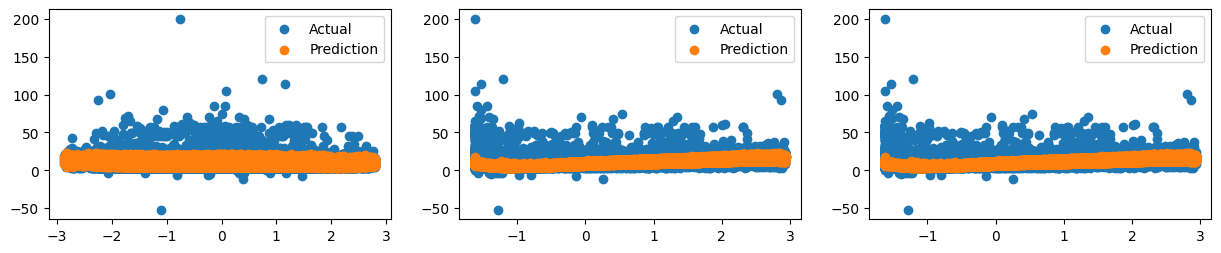

In [104]:
print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coefficient of the Regression Model was found to be ',PR.coef_)
print('The Intercept of the Regression Model was found to be ',PR.intercept_)
Evaluate(4, pred1, pred2)

## Random Forest Regression


<<<------------------------- Evaluating Random Forest Regression Model ------------------------->>>

Feature Importances:  [0.25648593 0.64028775 0.01468542 0.01081516 0.01246005 0.01120035
 0.00787312 0.0156765  0.01706041 0.0134553 ]


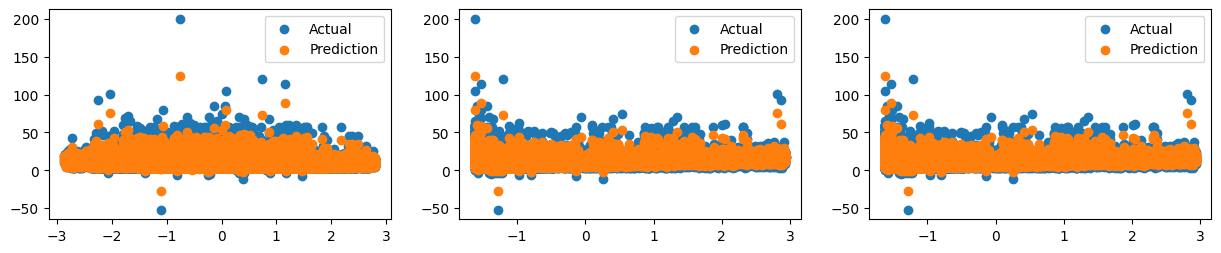

In [105]:
RFR = RandomForestRegressor(n_estimators=100, random_state=100).fit(Train_X_std, Train_Y)
pred1 = RFR.predict(Train_X_std)
pred2 = RFR.predict(Test_X_std)
print('{}{}\033[1m Evaluating Random Forest Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('Feature Importances: ', RFR.feature_importances_)
Evaluate(5, pred1, pred2)

## Gradient Boosting Regression

<<<------------------------- Evaluating Gradient Boosting Regression Model ------------------------->>>

Feature Importances:  [0.01885946 0.8862328  0.00199057 0.00671911 0.00790255 0.00465671
 0.00434393 0.02277714 0.03142166 0.01509607]


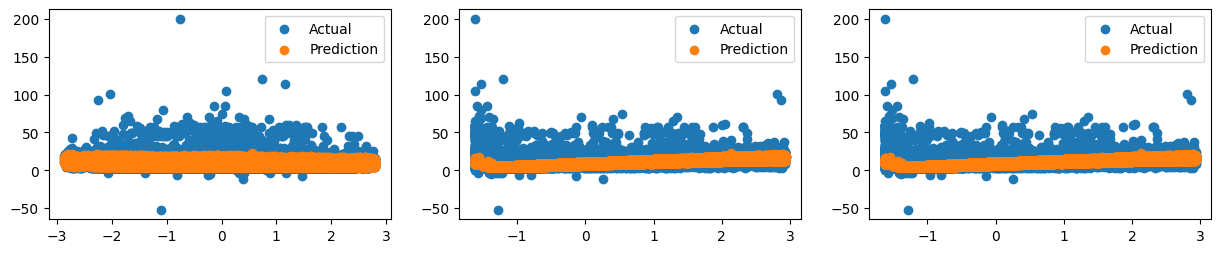

In [106]:
GBR = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=100).fit(Train_X_std, Train_Y)
pred1 = GBR.predict(Train_X_std)
pred2 = GBR.predict(Test_X_std)
print('{}{}\033[1m Evaluating Gradient Boosting Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('Feature Importances: ', GBR.feature_importances_)
Evaluate(6, pred1, pred2)

## Model Comparison

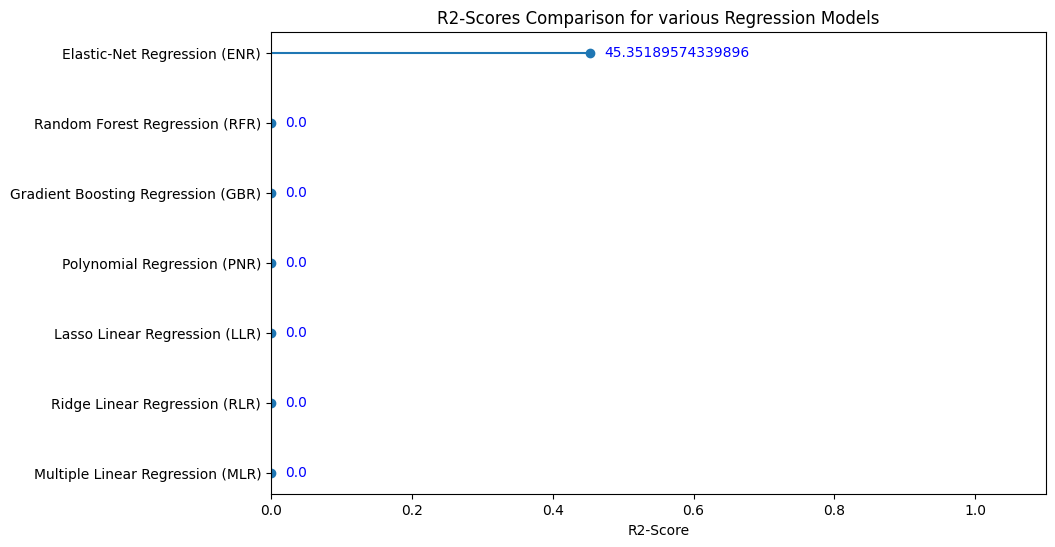

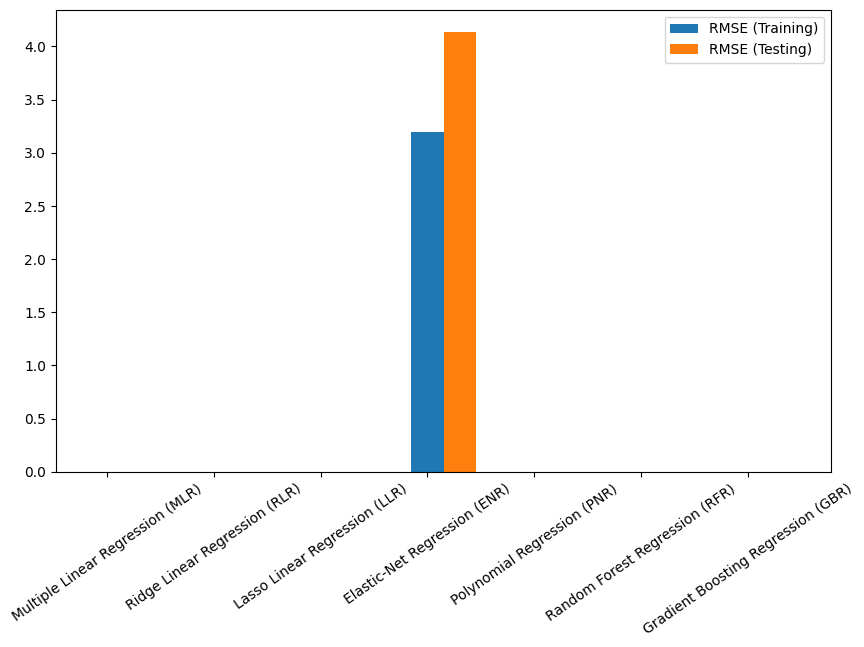

In [107]:
EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)', 'Ridge Linear Regression (RLR)', 'Lasso Linear Regression (LLR)',
             'Elastic-Net Regression (ENR)', 'Polynomial Regression (PNR)', 'Random Forest Regression (RFR)',
             'Gradient Boosting Regression (GBR)']
EMC
R2 = EMC['Train-R2'].sort_values(ascending=True)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v*100), color='blue')
plt.xlim([0,1.1])
plt.show()
cc = Model_Evaluation_Comparison_Matrix.columns.values
plt.bar(np.arange(7), Model_Evaluation_Comparison_Matrix[cc[6]].values, width=0.3, label='RMSE (Training)')
plt.bar(np.arange(7)+0.3, Model_Evaluation_Comparison_Matrix[cc[7]].values, width=0.3, label='RMSE (Testing)')
plt.xticks(np.arange(7), EMC.index, rotation=35)
plt.legend()
plt.show()